In [12]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy import spatial
from scipy.spatial import ConvexHull
from skimage.morphology import skeletonize
from sklearn.neighbors import NearestNeighbors
import open3d as o3d
import heapq

# from open3d import JVisualizer

# import scipy
# import scipy.interpolate
# import lipschitz

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


CPU times: total: 391 ms
Wall time: 32 ms


(-362.25, 5.0)

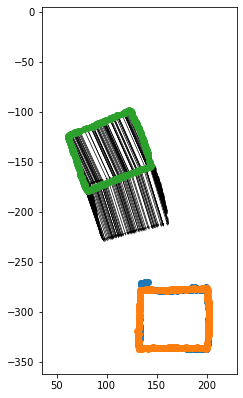

In [13]:
%%time
def icp(a, b, icp_radius = 200):
    a = np.hstack([a, np.zeros([a.shape[0],1])])
    b = np.hstack([b, np.zeros([b.shape[0],1])])
    src = o3d.geometry.PointCloud()
    dest = o3d.geometry.PointCloud()
    src.points = o3d.utility.Vector3dVector(a)
    dest.points = o3d.utility.Vector3dVector(b)
    reg_p2p = o3d.pipelines.registration.registration_icp(src, dest, icp_radius, np.identity(4),
                            o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return reg_p2p.transformation    

a = block1_boundary[np.random.choice(block1_boundary.shape[0], size=300, replace=False)]
b = block2_boundary[np.random.choice(block2_boundary.shape[0], size=300, replace=False)]

M2 = icp(a, b)
TF_Matrix = np.eye(3)
TF_Matrix[:2, :2] = M2[:2, :2]
TF_Matrix[:2, -1] = M2[:2, -1]

# src = np.array([a]).astype(np.float32)
# res = cv2.transform(src, TF_Matrix)


# split_rope3 = (TF_Matrix[:, :2]@a.T).T + TF_Matrix[:, -1]
pt1 = a[::-1]
pt2 = (TF_Matrix[:, :2]@pt1.T).T + TF_Matrix[:, -1]

fig = plt.figure(figsize=(12,12*720/1280))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.quiver(*pt1.T, *(pt2.T[:2]-pt1.T[:2]), scale=600)
ax.scatter(b.T[0],b.T[1])
ax.scatter(pt2.T[0], pt2.T[1])
ax.scatter(a.T[0], a.T[1])
ax.set_xlim(35, 230.25)
ax.set_ylim( -362.25, 5)
# plane_size = np.array([(35, 5),(230.25, -362.25)])
# ax.show()

In [19]:
(np.eye(3) - TF_Matrix)[:2,:2], 1000*np.mean((np.eye(3) - TF_Matrix)[:2,:2])

(array([[ 0.06741449, -0.36094912],
        [ 0.36094912,  0.06741449]]),
 33.707245545692764)

In [ ]:
len(block2_boundary)

In [ ]:
res = res[0]
res/res[:, -1][:,None]

In [ ]:
M, _ = cv2.findHomography(a,b, cv2.RANSAC)
M

In [ ]:
b.shape

In [ ]:

plt.scatter(c[:,0], c[:,1])

In [ ]:
b.shape, M.shape, np.hstack([b, np.ones((b.shape[0], 1))]).shape

In [ ]:
# c = cv2.transform(np.hstack([b, np.ones((b.shape[0], 1))]), M)
M, _ = cv2.findHomography(a,b, cv2.RANSAC)
src = np.array([a]).astype(np.float32)
c = cv2.transform(src, M)

plt.scatter(a[:,0], a[:,1])
plt.scatter(b[:,0], b[:,1])
# plt.plot(c[0].T[0], c[0].T[1], 'r.')

# BLOCK Detection

In [ ]:
sensitivity = 20
l_b=np.array([45, 10, 10])# lower hsv bound for red
u_b=np.array([80, 255, 255])# upper hsv bound to red
kernel = np.ones((31,31),np.uint8)
img_size = np.array((3840, 2160))
plane_size = np.array([(35, 5),(230.25, -362.25)])

def icp(a, b, icp_radius = 200):
    a = np.hstack([a, np.zeros([a.shape[0],1])])
    b = np.hstack([b, np.zeros([b.shape[0],1])])
    src = o3d.geometry.PointCloud()
    dest = o3d.geometry.PointCloud()
    src.points = o3d.utility.Vector3dVector(a)
    dest.points = o3d.utility.Vector3dVector(b)
    reg_p2p = o3d.pipelines.registration.registration_icp(src, dest, icp_radius, np.identity(4),
                            o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return reg_p2p.transformation    

def do_stuff(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(frame, l_b, u_b)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    contours,_= cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    max_contour = contours[0]
    for contour in contours:
        if cv2.contourArea(contour)>cv2.contourArea(max_contour):
            max_contour=contour
    boundary = max_contour.copy()
    boundary.resize(boundary.shape[0], boundary.shape[-1])
    # plt.imshow(mask)
    # plt.show()
    return boundary, max_contour

frame = cv2.imread("./test_data/block1.jpg")
b, max_contour = do_stuff(frame)
frame = cv2.imread("./test_data/block2.jpg")
a, max_contour = do_stuff(frame)

min_size = min(a.shape[0], b.shape[0])
a = a[np.random.choice(a.shape[0], size=min_size, replace=False)]
b = b[np.random.choice(b.shape[0], size=min_size, replace=False)]

M2 = icp(a, b, icp_radius=1000)
TF_Matrix = np.eye(3)
TF_Matrix[:2, :2] = M2[:2, :2]
TF_Matrix[:2, -1] = M2[:2, -1]
pt1 = a[::-1]
pt2 = (TF_Matrix[:, :2]@pt1.T).T + TF_Matrix[:, -1]

print(f"rot_error: {1000*np.mean((np.eye(3) - TF_Matrix)[:2,:2])}, trans_error: {np.mean(TF_Matrix[:2, -1])}")

frame = cv2.resize(frame, (frame.shape[1]//3, frame.shape[0]//3))
idxs = np.random.choice(a.shape[0], size=20, replace=False)
for idx in idxs:
    # print(pt1[idx], pt2[idx])
    cv2.arrowedLine(frame, pt1[idx]//3, pt2[idx][:2].astype(int)//3, color=(0, 255, 0))

# cv2.drawContours(frame, max_contour//3, -1, (0,255,0), 5)
# cv2.imshow("frame",frame)
ax.quiver(*pt1.T, *(pt2.T[:2]-pt1.T[:2]), scale=600)
ax.scatter(b.T[0],b.T[1])
ax.scatter(pt2.T[0], pt2.T[1])
ax.scatter(a.T[0], a.T[1])
ax.set_xlim(35, 230.25)
ax.set_ylim( -362.25, 5)
plt.pause(0.001)
plt.show()


pt2[:,1] = pt2[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]
pt2[:,0] = pt2[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]


In [3]:
""" Detection and masking parameters """
l_b=np.array([20, 80, 80])# lower hsv bound for red
u_b=np.array([33, 255, 255])# upper hsv bound to red
kernel = np.ones((31,31),np.uint8)

""" Robot positions and neighborhood parameters """
robot_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if j%2==0:
            robot_positions[i,j] = (j*37.5, -21.65 + i*-43.301)
            kdtree_positions[i*8 + j, :] = (-21.65 + i*-43.301, j*37.5)
        else:
            robot_positions[i,j] = (j*37.5, i*-43.301)
            kdtree_positions[i*8 + j, :] = (i*-43.301, j*37.5)

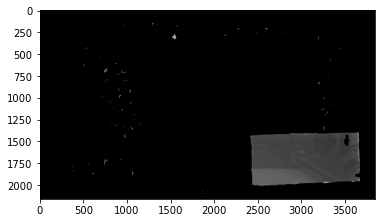

In [24]:
""" Actual Processing """
frame = cv2.imread("./test_data/block2.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(frame, l_b, u_b)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
contours,_= cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

max_contour = contours[0]
for contour in contours:
    if cv2.contourArea(contour)>cv2.contourArea(max_contour):
        max_contour=contour
        
plt.imshow(gray&mask, cmap="gray")

{(7, 4), (5, 5), (5, 4), (6, 4), (7, 6), (5, 6), (6, 6)}
[-285.77494692  192.8089172 ]


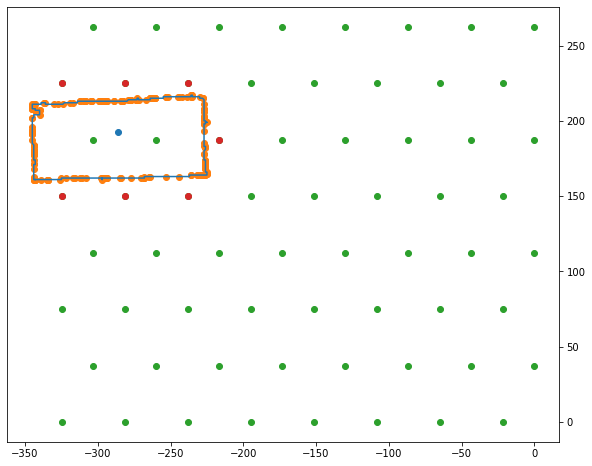

In [25]:
img_size = np.array((3840, 2160))
plane_size = np.array([(35, 5),(230.25, -362.25)])

boundary = max_contour.copy()
boundary.resize(boundary.shape[0], boundary.shape[-1])
boundary[:,1] = boundary[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]
boundary[:,0] = boundary[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]

smol_boundary = np.random.choice(range(len(boundary)), size=200, replace=False)

com = np.mean(boundary, axis=0)


hull = ConvexHull(boundary)
A, b = hull.equations[:, :-1], hull.equations[:, -1:]
eps = np.finfo(np.float32).eps

idxs = set()
for i in boundary[:,0][smol_boundary]:
    for j in boundary[:,1][smol_boundary]:
        idx = spatial.KDTree(kdtree_positions).query((i,j))[1]
        if np.all(np.flip(robot_positions[idx//8][idx%8]) @ A.T + b.T < eps, axis=1):
            continue
        else:
            idxs.add((idx//8, idx%8))
        
print(idxs)
idxs = np.array(list(idxs))
neighbors = robot_positions[idxs[:,0], idxs[:,1]]

print(com)
f = plt.figure(figsize=(8*1.237169,8)) 
ax = f.add_subplot(111)
# ax.gca().set_aspect('equal')
ax.scatter(*com)
ax.plot(boundary[:,0],boundary[:,1])
ax.scatter(boundary[:,0][smol_boundary],boundary[:,1][smol_boundary])
ax.scatter(kdtree_positions[:,0],kdtree_positions[:,1])
ax.scatter(neighbors[:,1],neighbors[:,0])
ax.yaxis.tick_right()

In [10]:
block1_boundary = a
block2_boundary = b

In [9]:
b = np.flip(boundary, axis=1)
# a = np.flip(boundary, axis=1)

In [ ]:
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
skeleton = skeletonize(mask//255, method='lee')
plt.imshow(skeleton)

# ROPE Detection

In [23]:
%%time
""" Detection and masking parameters """
sensitivity = 20
l_b=np.array([45,10,10])# lower hsv bound for green
u_b=np.array([85,255,255])# upper hsv bound to green
kernel = np.ones((31,31),np.uint8)

""" Robot positions and neighborhood parameters """
robot_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if j%2==0:
            robot_positions[i,j] = (j*37.5, -21.65 + i*-43.301)
            kdtree_positions[i*8 + j, :] = (-21.65 + i*-43.301, j*37.5)
        else:
            robot_positions[i,j] = (j*37.5, i*-43.301)
            kdtree_positions[i*8 + j, :] = (i*-43.301, j*37.5)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
class RopeSearch:
    def __init__(self, rope_coms, skeleton):
        self.rope_coms = rope_coms
        self.inv_rope_coms = {com.tobytes(): n for n, com in enumerate(self.rope_coms)}
        self.skeleton = skeleton
        self.map = {}
        self.make_map()
        self.graph = {}
    
    def make_map(self):
        self.end_points = []
        for idx in range(len(self.rope_coms)):
            neighbors = self.get_neighbors(idx)
            self.map[idx] = neighbors
            if (len(neighbors) == 1) or (len(neighbors) >= 3):
                self.end_points.append(idx)
                
    def get_neighbors(self, idx):
        xy = self.rope_coms[idx]
        crop = np.transpose(np.where(self.skeleton[xy[0]-1:xy[0]+2, xy[1]-1:xy[1]+2]==1)) - 1
        locs = xy + crop
        neighbors = locs[np.transpose(np.where(np.logical_or(locs[:,0]!=xy[0],locs[:,1]!=xy[1])))]
        neighbors = [self.inv_rope_coms[nbr.tobytes()] for nbr in neighbors]
        return neighbors
    
    def dijkstra(self):
        for idx in self.end_points:
            distances = {node: float('inf') for node in self.map}
            distances[idx] = 0
            visited = set()
            queue = [(0, idx)]
            while queue:
                dist, node = heapq.heappop(queue)
                if node in visited:
                    continue
                visited.add(node)
                for neighbor in self.map[node]:
                    if neighbor in visited:
                        continue
                    dist += 1
                    if dist < distances[neighbor]:
                        distances[neighbor] = dist
                        self.graph[neighbor] = node
                        heapq.heappush(queue, (dist, neighbor))
                        
            for idx2 in self.end_points:
                if distances[idx2] > self.rope_coms.shape[0]*0.9:
                    path = [idx2]
                    while idx2 != idx:
                        idx2 = self.graph[idx2]
                        path.append(idx2)
                    path.append(idx)
                    return path

In [ ]:
def get_rope_coms(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(frame, l_b, u_b)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    contours,_= cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    max_contour = contours[0]
    for contour in contours:
        if cv2.contourArea(contour)>cv2.contourArea(max_contour):
            max_contour=contour

    frame = cv2.resize(frame, (frame.shape[1]//3, frame.shape[0]//3))
    mask = cv2.resize(mask, (mask.shape[1]//3, mask.shape[0]//3))
    max_contour //= 3

#     kernel = np.ones((31,31),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    skeleton = skeletonize(mask//255, method='lee')
    rope_coms = np.array(np.where(skeleton==1)).T

    rope_search = RopeSearch(rope_coms, skeleton)
    rope_path = rope_search.dijkstra()
    rope_points = rope_coms[rope_path]

    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
    cv2.drawContours(frame, max_contour, -1, (0,255,0), 3)
    frame = cv2.polylines(frame, [np.flip(rope_points)], False, (0,255,255), 3)
    plt.figure(figsize=(16,9))
    plt.imshow(frame)
    return rope_points

In [ ]:
img_size = np.array((1280, 720))
plane_size = np.array([(35, 5),(230.25, -362.25)])

frame = cv2.imread("./test_data/rope1.jpg")
rope2 = np.flip(get_rope_coms(frame))
rope2[:,0] = rope2[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]
rope2[:,1] = rope2[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]
frame = cv2.imread("./test_data/rope0.jpg")
rope1 = np.flip(get_rope_coms(frame))
rope1[:,0] = rope1[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]
rope1[:,1] = rope1[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]

In [ ]:
plt.scatter(*rope2.T)

In [ ]:
%%time
# rope_points2 = rope_points
# rope_points1 = rope_points

split_rope1 = np.array_split(rope1, 15)
split_rope2 = np.array_split(rope2[::-1], 15)

# plt.scatter(*split_rope1[0].T)
# plt.scatter(*split_rope2[0].T)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.scatter(*rope1.T)
ax.scatter(*rope2.T)
for i in range(15):
    idx_thresh = min(split_rope1[i].shape[0], split_rope2[i].shape[0])
    M2 = icp(split_rope1[i][:idx_thresh],split_rope2[i][:idx_thresh], icp_radius = 300)
    TF_Matrix = np.zeros((2,3))
    TF_Matrix[:, :2] = M2[:2, :2]
    TF_Matrix[:, -1] = M2[:2, -1]
    
    split_rope3 = (TF_Matrix[:, :2]@split_rope1[i].T).T + TF_Matrix[:, -1]
    
    pt1 = split_rope1[i][0]
    pt2 = (TF_Matrix[:, :2]@pt1.T).T + TF_Matrix[:, -1]
    
    
    
    ax.quiver(*pt1, *(pt2-pt1), scale=600)
    
    ax.scatter(*pt1, color="red")
    ax.scatter(*pt2, color="purple")
    ax.plot(*split_rope3.T[:2], 'g.')

In [ ]:
split_rope3.shape

In [ ]:
import PIL
kernel = np.ones((31,31),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
skeleton = skeletonize(mask//255, method='lee')
rope_coms = np.array(np.where(skeleton==1)).T

# plt.figure(figsize=(16,9))
cv2.imwrite("./test_data/skeleton_rope.png",skeleton*255)
plt.imshow(skeleton)

In [ ]:
a = np.array([[1,2],[1,2]]).reshape((a.shape[0], -1))
a.shape

In [ ]:

                        
                
rope_search = RopeSearch(rope_coms, skeleton)
rope_path = rope_search.dijkstra()
rope_points = rope_coms[rope_path]
plt.scatter(rope_points[:,1], rope_points[:,0])

In [ ]:

plt.scatter(rope_points[:,1], rope_points[:,0])

In [ ]:
class rope_search:
    def __init__(self, rope_coms, skeleton, max_contour):
        self.rope_coms = rope_coms
        self.skeleton = skeleton
        self.max_contour = max_contour
        self.init_idx = np.argmin(np.linalg.norm(rope_coms - np.flip(max_contour[0,0]), axis=1))
        self.backup_init_idx = np.argmin(np.linalg.norm(rope_coms - np.flip(max_contour[0,0]), axis=1))
        self.thresh = len(rope_coms)//3
        
#         For Graph, key -> parent; value -> child 
        self.graph = dict()
        self.final_path = []
    
    def get_path_len(self, idx):
        path_len = 0
        while idx != self.init_idx:
            idx = self.graph(parent)
            path_len += 1
        return path_len
#         parents = [idx]
#         while parents[-1] != self.init_idx:
#             parents.append(self.graph(parents[-1]))
#         return len(parents), parents
    
    def get_neighbors(self, idx):
        xy = self.rope_coms[idx]
        crop = np.transpose(np.where(self.skeleton[xy[0]-1:xy[0]+2, xy[1]-1:xy[1]+2]==1)) - 1
        locs = xy + crop
        neighbors = np.squeeze(locs[np.transpose(np.where(np.logical_or(locs[:,0]!=xy[0],locs[:,1]!=xy[1])))])
        return neighbors
        
    def solver(self, idx, parent_idx):
        """ Takes initial node to start tree search
        Returns: Traversal Success, Complete path """
        neighbors = self.get_neighbors(idx)
        # Potential error -> Scalar can't be indexed. If no error, delete this comment
        if len(neighbors) == 1:
            neigh_idx = np.where(np.logical_and(self.rope_coms[:,0] == neighbor[0], self.rope_coms[:,1] == neighbor[1]))[0][0]
            if self.graph[neigh_idx] == idx:
                # For 1 neighbor, the only neighbor is parent
                length = self.get_path_len(idx)
                if length < self.thresh:
                    # Tail end of a smol branch
                    return False
                else:
                    self.path.append(idx)
                    return True
            else:
                return self.solver(neigh_idx, idx)
                
        elif len(neighbors) == 2:
            for neighbor in neighbors:
                neigh_idx = np.where(np.logical_and(self.rope_coms[:,0] == neighbor[0], self.rope_coms[:,1] == neighbor[1]))[0][0]
                if self.graph[neigh_idx] == idx:
                    # Parent Node -> Ignore
                    continue
                else:
                    self.graph[idx] = neigh_idx
                    soluchan, path = self.solver(neigh_idx, idx)
                    
                
        
        

rope_coms[np.argmin(np.linalg.norm(rope_coms - np.flip(max_contour[0,0]), axis=1))], max_contour[0,0][::-1]

def generate_path(skeleton, coms, start_idx):
    path_found = False
    while !path_found:
        

In [ ]:
MIN_MATCH_COUNT = 10

frame2 = cv2.imread("./test_data/block1.jpg")
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray,None)
kp2, des2 = sift.detectAndCompute(gray2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    gray2 = cv2.polylines(gray2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(gray,kp1,gray2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

In [ ]:
rope_coms

In [ ]:
# max_contour[0,0]
# x,y = rope_coms[np.argmin(np.linalg.norm(rope_coms - np.flip(max_contour[0,0]), axis=1))]
xy = rope_coms[23]
# print(xy, skeleton.shape)
skeleton[x-1:x+2, y-1:y+2], 

crop = np.array(np.where(skeleton[xy[0]-1:xy[0]+2, xy[1]-1:xy[1]+2]==1)).T
locs = xy + crop - 1
print(xy, locs,np.logical_or(locs[:,0]!=xy[0] , locs[:,1]!=xy[1]))
locs = np.squeeze(locs[np.transpose(np.where(np.logical_or(locs[:,0]!=xy[0],locs[:,1]!=xy[1])))])
locs

In [ ]:
np.where(np.logical_and(rope_coms[:,0] == 122, rope_coms[:,1] == 782))[0][0]

In [ ]:
a = np.sin(np.arange(0, 10, .01))
spl = scipy.interpolate.interp1d(np.arange(0, 10, .01), a)
dy = scipy.interpolate.splev(a,spl,der=1)
plt.plot(dy), a.shape

In [ ]:
grad_x = np.gradient(max_contour[:,:,0].ravel())
grad_x = np.gradient(grad_x)
plt.figure(figsize=(20, 4))
plt.plot(grad_x)

In [ ]:
2213//5

In [ ]:
plt.plot(max_contour[:,:,0])
plt.show()
plt.plot(max_contour[:,:,1])
plt.show()

In [ ]:
img_size = np.array((3840, 2160))
plane_size = np.array([(35, 5),(230.25, -362.25)])

boundary = max_contour.copy()
boundary.resize(boundary.shape[0], boundary.shape[-1])
boundary[:,1] = boundary[:,1]/img_size[1]*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]
boundary[:,0] = boundary[:,0]/img_size[0]*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]

smol_boundary = np.random.choice(range(len(boundary)), size=300, replace=False)

com = np.mean(boundary, axis=0)


hull = ConvexHull(boundary)
A, b = hull.equations[:, :-1], hull.equations[:, -1:]
eps = np.finfo(np.float32).eps

""" Get points inside a contour: 
    https://stackoverflow.com/questions/47337200/how-to-check-if-a-point-is-inside-a-set-of-contours """
idxs = set()
for i in boundary[:,0][smol_boundary]:
    for j in boundary[:,1][smol_boundary]:
        idx = spatial.KDTree(kdtree_positions).query((i,j))[1]
        if np.all(np.flip(robot_positions[idx//8][idx%8]) @ A.T + b.T < eps, axis=1):
            continue
        else:
            idxs.add((idx//8, idx%8))
        
# print(idxs)
idxs = np.array(list(idxs))
neighbors = robot_positions[idxs[:,0], idxs[:,1]]

# print(com)
f = plt.figure(figsize=(8*1.237169,8)) 
ax = f.add_subplot(111)
# ax.gca().set_aspect('equal')
ax.scatter(*com)
ax.plot(boundary[:,0],boundary[:,1])
ax.scatter(boundary[:,0][smol_boundary],boundary[:,1][smol_boundary])
ax.scatter(kdtree_positions[:,0],kdtree_positions[:,1])
ax.scatter(neighbors[:,1],neighbors[:,0])
ax.yaxis.tick_right()

In [ ]:
rope_coms[867]

In [ ]:
rope_coms[np.argmin(np.linalg.norm(rope_coms - np.flip(max_contour[0,0]), axis=1))]

In [ ]:
idx = spatial.KDTree(rope_coms).query((max_contour[0], max_contour[1]))[1]
if np.all(np.flip(robot_positions[idx//8][idx%8]) @ A.T + b.T < eps, axis=1):
    continue
else:
    idxs.add((idx//8, idx%8))

In [ ]:
rope_coms = np.array(np.where(skeleton==1)).T
rope_coms